### Agglomerative clustering using SBERT

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import transformers
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity

import pickle

/home/chanyat/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/chanyat/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# !pip install sentence_transformers

In [2]:
from sentence_transformers import SentenceTransformer

2024-12-10 11:28:00.148052: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 11:28:00.172918: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 11:28:00.180809: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 11:28:01.483540: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Loading the gpt generated files

In [ ]:
# TODO: (if necessary) change the path to where GPT results are 
folder_path_name = "gpt_data/"

all_bolly = folder_path_name + "entire_bollywood_gpt-4o.csv"
all_holly = folder_path_name + "entire_hollywood_gpt-4o.csv"

all_bolly_df = pd.read_csv(all_bolly)
all_holly_df = pd.read_csv(all_holly)

### Process the data to be in desired format

In [5]:
all_holly_df.columns

Index(['movie_id', 'subtitle_id', 'movie_name', 'release_year', 'decade',
       'context', 'lexicon_word_list', 'experience_social_emotion',
       'character', 'social_emotion', 'gender', 'reason'],
      dtype='object')

In [6]:
all_bolly_df.columns

Index(['movie_name', 'release_year', 'decade', 'movie_id', 'subtitle_id',
       'context', 'lexicon_word_list', 'experience_social_emotion',
       'character', 'social_emotion', 'gender', 'reason'],
      dtype='object')

In [126]:
def clean_decade(value):
    if isinstance(value, str) and value.endswith("s"):
        return int(value[:-1])  
    return int(value) if not pd.isnull(value) else None

In [ ]:
# include subtitle_id (message_id), who (character), gender, cause (reason), social_emotion
all_bolly_df = all_bolly_df[["subtitle_id", "decade", "experience_social_emotion", "character", "social_emotion", "gender", "reason"]]
all_bolly_df['decade'] = all_bolly_df['decade'].apply(clean_decade).astype(int)
bolly_emotion_present = all_bolly_df[all_bolly_df["experience_social_emotion"] == "yes"]
bolly_shame = bolly_emotion_present[bolly_emotion_present["social_emotion"] == "shame"]
bolly_pride = bolly_emotion_present[bolly_emotion_present["social_emotion"] == "pride"]

print(f"num bolly_pride: {bolly_pride.shape[0]}")
print(f"num bolly_shame: {bolly_shame.shape[0]}")
bolly_shame.columns

num bolly_pride: 1314
num bolly_shame: 2923


Index(['subtitle_id', 'decade', 'experience_social_emotion', 'character',
       'social_emotion', 'gender', 'reason'],
      dtype='object')

In [128]:
# iclude subtitle_id (message_id), who (character), gender, cause (reason), social_emotion
all_holly_df = all_holly_df[["subtitle_id", "decade", "experience_social_emotion", "character", "social_emotion", "gender", "reason"]]
all_holly_df['decade'] = all_holly_df['decade'].apply(clean_decade).astype(int)
holly_emotion_present = all_holly_df[all_holly_df["experience_social_emotion"] == "yes"]
holly_shame = holly_emotion_present[holly_emotion_present["social_emotion"] == "shame"]
holly_pride = holly_emotion_present[holly_emotion_present["social_emotion"] == "pride"]

print(f"num holly_pride: {holly_pride.shape[0]}")
print(f"num holly_shame: {holly_shame.shape[0]}")

num holly_pride: 1338
num holly_shame: 1026


In [129]:
# drop NA reasons
bolly_shame = bolly_shame[bolly_shame['reason'].notna()]
holly_shame = holly_shame[holly_shame['reason'].notna()]

holly_pride = holly_pride[holly_pride['reason'].notna()]
bolly_pride = bolly_pride[bolly_pride['reason'].notna()]

In [130]:
print(f"num holly_pride: {holly_pride.shape[0]}")
print(f"num holly_shame: {holly_shame.shape[0]}")
print(f"num bolly_pride: {bolly_pride.shape[0]}")
print(f"num bolly_shame: {bolly_shame.shape[0]}")

num holly_pride: 1338
num holly_shame: 1026
num bolly_pride: 1314
num bolly_shame: 2923


In [131]:
### removing unknowns
searchfor = ['unknown', 'not specified']
bolly_shame = bolly_shame[~bolly_shame.reason.str.contains('|'.join(searchfor))]
holly_shame = holly_shame[~holly_shame.reason.str.contains('|'.join(searchfor))]
bolly_pride = bolly_pride[~bolly_pride.reason.str.contains('|'.join(searchfor))]
holly_pride = holly_pride[~holly_pride.reason.str.contains('|'.join(searchfor))]

print(f'after removing unknowns- bolly_shame={len(bolly_shame["reason"])}, holly_shame={len(holly_shame["reason"])}')
print(f'after removing unknowns- bolly_pride={len(bolly_pride["reason"])}, holly_pride={len(holly_pride["reason"])}')


after removing unknowns- bolly_shame=2921, holly_shame=1026
after removing unknowns- bolly_pride=1314, holly_pride=1338


In [ ]:

## saving files
file_path = "processed_data/"
bolly_shame.to_csv(file_path+"bolly_shame_woNAs.csv")
holly_shame.to_csv(file_path+"holly_shame_woNAs.csv")
bolly_pride.to_csv(file_path+"bolly_pride_woNAs.csv")
holly_pride.to_csv(file_path+"holly_pride_woNAs.csv")

after removing unknowns- bolly_shame=2921, holly_shame=1026
after removing unknowns- bolly_pride=1314, holly_pride=1338


In [132]:
bolly_shame.head()

,subtitle_id,decade,experience_social_emotion,character,social_emotion,gender,reason
0,18,2010,yes,buddy Gurpreet,shame,male,for shying away from girls and fearing lifelon...
1,156,2010,yes,unspecified character,shame,unspecified gender,for repeatedly using the same excuse about boy...
2,352,2010,yes,Gurpreet,shame,male,for not being able to get a visa due to all pr...
4,534,1960,yes,Unnamed Character,shame,unknown,for being single and discussing marriage.
5,587,1960,yes,unspecified character,shame,unspecified gender,for feeling ashamed to look at someone they love


In [135]:
bolly_shame_decade = bolly_shame.groupby('decade').size()
# print(bolly_shame_decade)
bolly_pride_decade = bolly_pride.groupby('decade').size()
# print(bolly_pride_decade)
holly_shame_decade = holly_shame.groupby('decade').size()
print(holly_shame_decade)
holly_pride_decade = holly_pride.groupby('decade').size()
print(holly_pride_decade)

decade
1910      4
1920      1
1930     40
1940     73
1950     53
1960     71
1970     67
1980     85
1990    148
2000    239
2010    245
dtype: int64
decade
1910      2
1920      2
1930     40
1940     65
1950     74
1960     57
1970     59
1980     89
1990    201
2000    335
2010    414
dtype: int64


In [108]:
bolly_shame = pd.read_csv(folder_path+"bolly_shame_woNAs.csv")
bolly_shame.shape[0]

2921

In [109]:
## WITHOUT DUPLICATES
## removing duplicates for gender analysis - there could be a particular genre over-present in one set of movies - skewing gender association - removing duplicates.
remove_duplicates = False


print(f'Not deduplicating - bolly_shame={len(bolly_shame["reason"])}, holly_shame={len(holly_shame["reason"])}')
print(f'Not deduplicating - bolly_pride={len(bolly_pride["reason"])}, holly_pride={len(holly_pride["reason"])}')
print("-"*50)

if remove_duplicates:
  bolly_shame = bolly_shame.drop_duplicates(subset='reason', keep="last")
  holly_shame = holly_shame.drop_duplicates(subset='reason', keep="last")
  bolly_pride = bolly_pride.drop_duplicates(subset='reason', keep="last")
  holly_pride = holly_pride.drop_duplicates(subset='reason', keep="last")

  print(f'after deduplicating - bolly_shame={len(bolly_pride["reason"])}, holly_shame={len(holly_shame["reason"])}')
  print(f'after deduplicating - bolly_pride={len(bolly_pride["reason"])}, holly_pride={len(holly_pride["reason"])}')

Not deduplicating - bolly_shame=2921, holly_shame=1026
Not deduplicating - bolly_pride=1314, holly_pride=1338
--------------------------------------------------


In [44]:
bolly_shame.head()

,subtitle_id,decade,experience_social_emotion,character,social_emotion,gender,reason
0,18,2010,yes,buddy Gurpreet,shame,male,for shying away from girls and fearing lifelon...
1,156,2010,yes,unspecified character,shame,unspecified gender,for repeatedly using the same excuse about boy...
2,352,2010,yes,Gurpreet,shame,male,for not being able to get a visa due to all pr...
4,534,1960,yes,Unnamed Character,shame,unknown,for being single and discussing marriage.
5,587,1960,yes,unspecified character,shame,unspecified gender,for feeling ashamed to look at someone they love


In [17]:
from collections import defaultdict

In [96]:
decade_list = [1960, 1970, 1980, 1990, 2000, 2010]
def create_df_list(df):
    df_list = defaultdict(list)
    for decade in decade_list:
        decade_df = df[(df['decade'] == decade)]
        df_list[decade] = decade_df
    return df_list

In [ ]:
b_shame_list = create_df_list(bolly_shame)
b_pride_list = create_df_list(bolly_pride)

h_shame_list = create_df_list(holly_shame)
h_pride_list = create_df_list(holly_pride)


### Clustering

In [ ]:
# change it to include subtitle_id to allow for backtracking
bolly_shame = bolly_shame[["reason", "subtitle_id"]].values.tolist()
bolly_pride = bolly_pride[["reason", "subtitle_id"]].values.tolist()
holly_shame = holly_shame[["reason", "subtitle_id"]].values.tolist()
holly_pride = holly_pride[["reason", "subtitle_id"]].values.tolist()
all_shame = bolly_shame + holly_shame
all_pride = bolly_pride + holly_pride

In [122]:
len(all_shame)

3947

In [123]:
len(bolly_shame)

2921

In [124]:
len(holly_shame)

1026

In [10]:
ENCODE = False # first time encoding
without_duplicate = True


In [11]:
folder_path = "processed_data/"

In [12]:
if(ENCODE == True and without_duplicate== True):
     #get embeddings from sbert for each sentence
    model = SentenceTransformer('all-mpnet-base-v2')
    embeddings_shame = model.encode(all_shame, show_progress_bar=True)
    pickle.dump(embeddings_shame, open(folder_path+"shame_embeddings_woduplicates.pkl", 'wb'))
    print("shame (without duplicates) embeddings saved")
    embeddings_pride = model.encode(all_pride, show_progress_bar=True)
    pickle.dump(embeddings_pride, open(folder_path+"pride_embeddings_woduplicates.pkl", 'wb'))
    print("pride (without duplicates) embeddings saved")

if ENCODE== True and without_duplicate==False:
    #get embeddings from sbert for each sentence
    model = SentenceTransformer('all-mpnet-base-v2')
    embeddings_shame = model.encode(all_shame, show_progress_bar=True)
    pickle.dump(embeddings_shame, open(folder_path+"shame_embeddings.pkl", 'wb'))
    print("shame embeddings (with duplicates) saved")
    embeddings_pride = model.encode(all_pride, show_progress_bar=True)
    pickle.dump(embeddings_pride, open(folder_path+"pride_embeddings.pkl", 'wb'))
    print("pride embeddings (with duplicates) saved")

if ENCODE== False and without_duplicate==True:
    embeddings_shame = pickle.load(open(folder_path+"shame_embeddings_woduplicates.pkl", 'rb'))
    embeddings_pride = pickle.load(open(folder_path+"pride_embeddings_woduplicates.pkl", 'rb'))
    print("embeddings without duplicates are loaded")

if ENCODE==False and without_duplicate == False:
    embeddings_shame = pickle.load(open(folder_path+"shame_embeddings.pkl", 'rb'))
    embeddings_pride = pickle.load(open(folder_path+"pride_embeddings.pkl", 'rb'))
    print("embeddings with duplicates are loaded.")
    


embeddings without duplicates are loaded


In [13]:
# all_shame

In [48]:

def create_embeddings(ENCODE, without_duplicate, all_shame, all_pride):

  folder_path = f"processed_data/{decade}"

  if(ENCODE == True and without_duplicate== True):
      #get embeddings from sbert for each sentence
      model = SentenceTransformer('all-mpnet-base-v2')
      embeddings_shame = model.encode(all_shame, show_progress_bar=True)
      pickle.dump(embeddings_shame, open(folder_path+"shame_embeddings_woduplicates.pkl", 'wb'))
      print("shame (without duplicates) embeddings saved")
      embeddings_pride = model.encode(all_pride, show_progress_bar=True)
      pickle.dump(embeddings_pride, open(folder_path+"pride_embeddings_woduplicates.pkl", 'wb'))
      print("pride (without duplicates) embeddings saved")

  if ENCODE== True and without_duplicate==False:
    #get embeddings from sbert for each sentence
    model = SentenceTransformer('all-mpnet-base-v2')
    embeddings_shame = model.encode(all_shame, show_progress_bar=True)
    pickle.dump(embeddings_shame, open(folder_path+"shame_embeddings.pkl", 'wb'))
    print("shame embeddings (with duplicates) saved")
    embeddings_pride = model.encode(all_pride, show_progress_bar=True)
    pickle.dump(embeddings_pride, open(folder_path+"pride_embeddings.pkl", 'wb'))
    print("pride embeddings (with duplicates) saved")

  if ENCODE== False and without_duplicate==True:
      embeddings_shame = pickle.load(open(folder_path+"shame_embeddings_woduplicates.pkl", 'rb'))
      embeddings_pride = pickle.load(open(folder_path+"pride_embeddings_woduplicates.pkl", 'rb'))
      print("embeddings without duplicates are loaded")

  if ENCODE==False and without_duplicate == False:
    embeddings_shame = pickle.load(open(folder_path+"shame_embeddings.pkl", 'rb'))
    embeddings_pride = pickle.load(open(folder_path+"pride_embeddings.pkl", 'rb'))
    print("embeddings with duplicates are loaded.")
    
  return embeddings_shame, embeddings_pride

In [ ]:
#perform kmeans clustering on embeddings 
## distance_threshold = 5
## SET EMBEDDINGS
def set_embeddings(distance_threshold, emotion):

    if emotion == "shame":
        embeddings = embeddings_shame
        input = all_shame
        # embeddings = emb_shame_list[decade]
        # input = all_shame_list[decade]
    elif emotion == "pride":
        embeddings = embeddings_pride
        input = all_pride
        # embeddings = emb_pride_list[decade]
        # input = all_pride_list[decade]

    clustering_model = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=None)
    clustering_model.fit_predict(embeddings)
    cluster_assignment = clustering_model.labels_
    
    print(cluster_assignment)

    num_clusters = cluster_assignment.max()+1
    print("Number of clusters: ", num_clusters)

    ## PRIDE ##
    ## merging cluster assignment with gender-norm table
    cluster_assignment_df = pd.DataFrame(cluster_assignment, columns =['Cluster_ID'])
    #cluster_assignmentdf.head()

    input_df = pd.DataFrame(input, columns=['reason', 'subtitle_id']) 
    clustered_data = pd.concat([input_df, cluster_assignment_df], axis=1)
    # grouped_by_decade_reason = clustered_data.groupby(['decade', 'reason', 'Cluster_ID'])

    #save the file - cluster assignements
    file_path = f"processed_data/"
    clustered_data.to_csv(file_path+emotion+"_norms_dist"+str(distance_threshold)+"_decade_woduplicates.csv")
    
    return embeddings, num_clusters, cluster_assignment, input

### Cross-validation for number of clusters 2,3,5,7,10

In [15]:
from sklearn.metrics import silhouette_score

def evaluate_clusters(embeddings, cluster_assignment):
    # Silhouette score is only valid if more than 1 cluster exists
    if len(set(cluster_assignment)) > 1:
        return silhouette_score(embeddings, cluster_assignment)
    else:
        return -1  # Return a bad score for single cluster


In [59]:
shame_results = defaultdict(list)
distance_thresholds = [2, 3, 4, 5, 7, 10]  

print("for shame:")
for threshold in distance_thresholds:
    embeddings, num_clusters, cluster_assignment, input = set_embeddings(threshold, emotion="shame")
    score = evaluate_clusters(embeddings, cluster_assignment)
    shame_results[threshold] = [score, embeddings, num_clusters, cluster_assignment, input]
    print(f"Threshold: {threshold}, Clusters: {num_clusters}, Score: {score}")

for shame:
[53 63 58 ...  2 33 11]
Number of clusters:  100
Threshold: 2, Clusters: 100, Score: 0.004480092786252499
[ 3 15 26 ...  1  5  7]
Number of clusters:  36
Threshold: 3, Clusters: 36, Score: -0.0035195290111005306
[ 1  9 12 ...  6 11  3]
Number of clusters:  15
Threshold: 4, Clusters: 15, Score: 0.01024758629500866
[ 3  9  0 ...  6 11  7]
Number of clusters:  12
Threshold: 5, Clusters: 12, Score: 0.004148112144321203
[2 4 2 ... 0 3 1]
Number of clusters:  6
Threshold: 7, Clusters: 6, Score: 0.006151128094643354
[0 2 0 ... 2 0 1]
Number of clusters:  3
Threshold: 10, Clusters: 3, Score: 0.02015293948352337


In [95]:
# shame_results[5]
# shame_results[5][4]

In [60]:
pride_results = defaultdict(list)
distance_thresholds = [2, 3, 4, 5, 7, 10]  

print("for pride:")
for threshold in distance_thresholds:
    embeddings, num_clusters, cluster_assignment, input = set_embeddings(threshold, emotion="pride")
    score = evaluate_clusters(embeddings, cluster_assignment)
    pride_results[threshold] = [score, embeddings, num_clusters, cluster_assignment, input]
    print(f"Threshold: {threshold}, Clusters: {num_clusters}, Score: {score}")

for pride:
[60 11 51 ... 30 11 46]
Number of clusters:  76
Threshold: 2, Clusters: 76, Score: -0.004782023839652538
[21 12 22 ... 18 12 11]
Number of clusters:  27
Threshold: 3, Clusters: 27, Score: 0.0046006543561816216
[5 4 6 ... 8 4 1]
Number of clusters:  16
Threshold: 4, Clusters: 16, Score: 0.012417430989444256
[0 1 1 ... 8 1 2]
Number of clusters:  9
Threshold: 5, Clusters: 9, Score: 0.023471763357520103
[0 4 4 ... 1 4 1]
Number of clusters:  5
Threshold: 7, Clusters: 5, Score: 0.02010381408035755
[0 1 1 ... 1 1 1]
Number of clusters:  2
Threshold: 10, Clusters: 2, Score: 0.04093053191900253


In [22]:
#let's take threshold = 5
threshold = 7
s_score, shame_embeddings, num_shame_clusters, shame_ca, shame_input = shame_results[threshold]
p_score, pride_embeddings, num_pride_clusters, pride_ca, pride_input = pride_results[threshold]

In [61]:
# testing out lower scores
threshold = 4
s_score, shame_embeddings, num_shame_clusters, shame_ca, shame_input = shame_results[threshold]
p_score, pride_embeddings, num_pride_clusters, pride_ca, pride_input = pride_results[threshold]

In [28]:
# # for decade in decade_list:
# #     print(f"processing: {decade}")
# print("setting embedding for shame")
# shame_embeddings, shame_n_clusters, shame_ca, shame_input = set_embeddings(5, "shame")
# print("setting embedding for pride")
# pride_embeddings, pride_n_clusters, pride_ca, pride_input = set_embeddings(5, "pride")


In [100]:
# pride_input

In [62]:
#get the 10 sentences closest to each cluster centers
def get_closest_sentences(embeddings, cluster_assignment, emotion, num_clusters, input_sentences):
    center_embeddings = []
    for i in range(num_clusters):
        cluster_center = embeddings[cluster_assignment==i].mean(axis=0)
        center_embeddings.append(cluster_center)
        
    print(f"center_embeddings: {center_embeddings}")

    closest_sentences = []
    for i in range(num_clusters):
        cluster_center = center_embeddings[i]
        distances = cosine_similarity([cluster_center], embeddings)
        closest = np.argsort(distances[0])[::-1][:10]
        ### change file name: all_shame or all_pride 
        # add subtitle_id too
        sentences = [(input_sentences[idx][0], input_sentences[idx][1]) for idx in closest]
        # sentences = [input_sentences[idx] for idx in closest]
        closest_sentences.append((i,sentences))
    
    print(f"center_embeddings: {closest_sentences}")


    # cluster_examples = pd.DataFrame(closest_sentences)
    cluster_examples = pd.DataFrame({
        "Cluster_ID": [cluster[0] for cluster in closest_sentences],
        "Closest_Sentences": [[(reason) for reason, _ in cluster[1]] for cluster in closest_sentences],
        "Subtitle_ID": [[(subtitle_id) for _, subtitle_id in cluster[1]] for cluster in closest_sentences],
    })

    ## saving files
    file_path = "processed_data/"
    # change threshold here
    cluster_examples.to_csv(file_path+emotion+"_id_norms_dist_"+str(threshold)+"_woduplicates_examples.csv")

    # for i, sentences in enumerate(closest_sentences):
    #     print("Cluster ", i, ": ", sentences)
    for cluster_id, sentences in closest_sentences:
        print(f"Cluster {cluster_id}:")
        for reason, subtitle_id in sentences:
            print(f"  Subtitle_ID: {subtitle_id}, Reason: {reason}")
        
    return cluster_examples

In [63]:
shame_examples = get_closest_sentences(shame_embeddings, shame_ca, "shame", num_shame_clusters, shame_input)
pride_examples = get_closest_sentences(pride_embeddings, pride_ca, "pride", num_pride_clusters, pride_input)

center_embeddings: [array([ 1.90971177e-02,  2.05055490e-04,  2.10465938e-02, -4.00534198e-02,
       -2.99201049e-02,  3.76036726e-02,  1.90773942e-02, -1.26918452e-02,
        3.15058642e-05, -2.63598263e-02, -4.38588765e-03, -3.78275551e-02,
        9.60363168e-03, -2.28543170e-02, -6.56726654e-04,  4.80395146e-02,
        1.67192221e-02,  3.60756740e-02,  4.71258573e-02, -1.30849937e-02,
        5.18730246e-02,  1.06117558e-02,  6.20900653e-03,  1.77285541e-02,
       -5.19281588e-02, -3.72796543e-02,  1.45985279e-03,  2.14154981e-02,
        2.72640754e-02,  2.09183656e-02, -3.11325453e-02, -3.82771790e-02,
        2.33651344e-02, -5.94710857e-02,  1.24875714e-06,  6.55861851e-03,
       -2.15302166e-02, -3.92703339e-03, -4.82205814e-03,  8.48042686e-03,
       -1.16514834e-02, -3.63606326e-02, -8.73581972e-03,  2.08560564e-02,
        2.47201254e-03, -2.53055454e-03,  1.24096731e-02,  1.39361555e-02,
        2.15275977e-02,  1.08132521e-02, -1.81396455e-02, -2.39047245e-03,
     

In [50]:
# shame_examples # top 20 matching sentences

In [26]:
pride_examples

,Cluster_ID,Closest_Sentences,Subtitle_ID
0,0,"[for being very proud of himself., for being p...","[445, 7, 1274340, 1259094, 131955, 312, 2231, ..."
1,1,[for being successful and receiving recognitio...,"[1887, 1144382, 2776349, 309, 1556988, 1235, 3..."
2,2,[for achieving something that made her father ...,"[2584291, 1090278, 155, 1665, 1563, 2827965, 2..."
3,3,[for winning a gold medal and making India pro...,"[886, 1669, 430, 1010, 1401, 64, 1560, 133, 26..."
4,4,[for doing what he felt was right and being re...,"[2076, 1115726, 43, 1978650, 456128, 275, 71, ..."


In [69]:
filepath = "processed_data/"
bolly_shame = pd.read_csv(filepath+"bolly_shame_woNAs.csv")
holly_shame = pd.read_csv(filepath+"holly_shame_woNAs.csv")
bolly_pride = pd.read_csv(filepath+"bolly_pride_woNAs.csv")
holly_pride = pd.read_csv(filepath+"holly_pride_woNAs.csv")

## assign movie industry flag before concatenating tables.
bolly_shame['movie_industry']=1
holly_shame['movie_industry']=0
bolly_pride['movie_industry']=1
holly_pride['movie_industry']=0

## concatenation
all_shame = pd.concat([holly_shame, bolly_shame])
all_pride= pd.concat([bolly_pride, holly_pride])

In [38]:
all_shame.head()
# holly is 0, bolly is 1

,Unnamed: 0,subtitle_id,decade,experience_social_emotion,character,social_emotion,gender,reason,movie_industry
0,3,3676,1990,yes,speaker,shame,male,for his father's inability to live with the sh...,0
1,8,11596,1990,yes,Cher,shame,female,for being unsupportive of someone's feelings f...,0
2,13,14905,1990,yes,Pocahontas,shame,female,for disobeying her father and causing Kocoum's...,0
3,16,16445,1990,yes,unknown,shame,unknown,for hurting someone,0
4,31,32813,1990,yes,brother,shame,male,for being compared unfavorably to his past sel...,0


In [70]:
pride_clusterIDs = pd.read_csv(filepath+"pride_norms_dist4_decade_woduplicates.csv")
shame_clusterIDs = pd.read_csv(filepath+"shame_norms_dist4_decade_woduplicates.csv")

In [71]:
pride_clusterIDs.head()

,Unnamed: 0,reason,subtitle_id,Cluster_ID
0,0,for having a lovely family and a fulfilling life.,326,5
1,1,for seeing his son Rishi grow up and prove him...,322,4
2,2,for seeing a son stand up to his father for hi...,763,6
3,3,for being involved in a successful company pro...,442,12
4,4,for being a busy bank investor and having dinn...,345,9


In [ ]:
all_shame

In [74]:
shame_clusterIDs_decade = pd.merge(
    all_shame[['subtitle_id', 'reason', 'decade', 'gender', 'experience_social_emotion', 'movie_industry']], #1 is bolly, 0 is holly
    shame_clusterIDs[['reason', 'subtitle_id', 'Cluster_ID']],
    on=['subtitle_id', 'reason'],
    how='inner'
)
print(shame_clusterIDs_decade.shape[0])
shame_clusterIDs_decade.head()

3947


,subtitle_id,reason,decade,gender,experience_social_emotion,movie_industry,Cluster_ID
0,3676,for his father's inability to live with the sh...,1990,male,yes,0,7
1,11596,for being unsupportive of someone's feelings f...,1990,female,yes,0,8
2,14905,for disobeying her father and causing Kocoum's...,1990,female,yes,0,11
3,16445,for hurting someone,1990,unknown,yes,0,0
4,32813,for being compared unfavorably to his past sel...,1990,male,yes,0,10


In [86]:
pride_clusterIDs_decade = pd.merge(
    all_pride[['subtitle_id', 'reason', 'decade', 'movie_industry', 'gender']], #1 is bolly, 0 is holly
    pride_clusterIDs[['reason', 'subtitle_id', 'Cluster_ID']],
    on=['subtitle_id', 'reason'],
    how='inner'
)
print(pride_clusterIDs_decade.shape[0])
pride_clusterIDs_decade.head()

2654


,subtitle_id,reason,decade,movie_industry,gender,Cluster_ID
0,326,for having a lovely family and a fulfilling life.,1960,1,male,5
1,322,for seeing his son Rishi grow up and prove him...,2020,1,male,4
2,763,for seeing a son stand up to his father for hi...,2020,1,unknown,6
3,442,for being involved in a successful company pro...,2020,1,female,12
4,345,for being a busy bank investor and having dinn...,2010,1,male,9


In [ ]:
# map cluster ids to concatenated files
mapped_shame = pd.merge(all_shame, shame_clusterIDs, how="left", on="reason")
mapped_pride = pd.merge(all_pride, pride_clusterIDs, how="left", on="reason")

print("Original tables:", len(all_shame), len(all_pride))
print ("After mapping:", len(mapped_shame), len(mapped_pride))

Original tables: 3947 2652
After mapping: 3951 2684


In [ ]:
file_path = "processed_data/"
shame_clusterIDs_decade.to_csv(filepath+"shameNormsMappedtoClusters.csv")
pride_clusterIDs_decade.to_csv(filepath+"prideNormsMappedtoClusters.csv")

In [ ]:
pride_clusterIDs_decade = pd.read_csv(file_path+"prideNormsMappedtoClusters.csv")

In [5]:
pride_clusterIDs_decade.columns

Index(['Unnamed: 0', 'subtitle_id', 'reason', 'decade', 'movie_industry',
       'Cluster_ID'],
      dtype='object')

In [87]:
shame_clusterIDs_decade.columns

Index(['subtitle_id', 'reason', 'decade', 'gender',
       'experience_social_emotion', 'movie_industry', 'Cluster_ID'],
      dtype='object')

In [6]:
pride_clusterIDs_decade.columns
Pride_clusterDistxmovieIndustry =  pride_clusterIDs_decade.groupby(['movie_industry', 'Cluster_ID', 'decade']).size().unstack(fill_value=0)

In [96]:
# Create the contingency table
Shame_clusterDistxmovieIndustry =  shame_clusterIDs_decade.groupby(['movie_industry', 'Cluster_ID', 'decade']).size().unstack(fill_value=0)
Pride_clusterDistxmovieIndustry =  pride_clusterIDs_decade.groupby(['movie_industry', 'Cluster_ID', 'decade']).size().unstack(fill_value=0)

In [102]:
Shame_clusterDistxmovieIndustry.to_csv(folder_path+"shame_cluster_decade.csv", index=True)

In [7]:
Pride_clusterDistxmovieIndustry

decade                     1910  1920  1930  1940  1950  1960  1970  1980  \
movie_industry Cluster_ID                                                   
0              0              1     0     4     6     4     5     6     3   
               1              0     0     2     5     3     2     4     7   
               2              0     0     2     8     5     5     4    11   
               3              0     0     4    10    12     4     6    11   
               4              0     0     2     5     5     7     5     6   
               5              0     0     3     0     3     3     5     5   
               6              0     0     2     4    10     9     2     5   
               7              0     0     0     0     0     1     0     1   
               8              0     0     3     1     7     2     4     1   
               9              0     0     1     2     4     4     7     9   
               10             0     0     1     4     2     3     1     6   
               11             0     0     4     7     5     0     0     5   
               12             0     1     4     2     4     0     4     3   
               13             0     0     5     7     3     6     3     5   
               14             1     1     2     4     5     6     7     9   
               15             0     0     1     0     2     0     1     2   
1              0              0     0     0     2     1     7     4     7   
               1              0     0     0     2     1     3     5     7   
               2              0     0     0     0     1     3     8     6   
               3              0     0     0     0     2     8     5    12   
               4              0     0     0     0     1    12     7    13   
               5              0     0     0     0     1     4     9    10   
               6              0     0     0     1     1     4     7     8   
               7              0     0     0     0     1     7     7    18   
               8              0     0     0     0     0     2     1     2   
               9              0     0     0     1     0     4     3    11   
               10             0     0     0     0     0     0     4     4   
               11             0     0     0     0     0     4     8     7   
               12             0     0     0     1     0     6     6     7   
               13             0     0     0     0     1     3     5    14   
               14             0     0     0     0     0     1     7     5   
               15             0     0     0     0     2     0     2     5   

decade                     1990  2000  2010  2020  
movie_industry Cluster_ID                          
0              0             14    31    23     0  
               1             15    18    25     0  
               2             21    35    74     0  
               3             22    25    32     0  
               4             12    29    38     0  
               5              9    18    20     0  
               6             14    21    12     0  
               7              0     2     2     0  
               8              5     9    26     0  
               9             15    27    27     0  
               10            13    21    28     0  
               11            11    13    24     0  
               12             9    13    20     0  
               13            15    20    13     0  
               14            21    44    45     0  
               15             5     9     5     0  
1              0             18    18    52     0  
               1              8    17    23     0  
               2              8    26    33     0  
               3             25    19    22     0  
               4             20    27    38     4  
               5             10    16    19     0  
               6             19    28    32     5  
               7             19    51    73     7  
               8             

In [103]:
Shame_clusterDistxmovieIndustry

decade                     1910  1920  1930  1940  1950  1960  1970  1980  \
movie_industry Cluster_ID                                                   
0              0              0     0    10     6     6     7     6     8   
               1              1     0     3     6     9     8     6     8   
               2              0     0     4    15     5     7    15    17   
               3              0     0     1     4     3     5     7     8   
               4              0     0     2     3     1     3     3     4   
               5              0     0     0     6     4     1     0     7   
               6              0     0     0     4     2     2     3     3   
               7              0     0     2     2     2     4     1     3   
               8              0     0     1     5     3     8     5     9   
               9              0     0     1     0     0     0     0     0   
               10             1     0     3     7     9     5     4     5   
               11             1     1     7     8     3     8     6     4   
               12             1     0     2     2     1     7     4     5   
               13             0     0     2     2     1     2     4     3   
               14             0     0     2     3     4     4     3     1   
1              0              0     0     0     1    12    23    49    62   
               1              0     0     0     0    11    15    35    29   
               2              0     0     0     0    10    19    35    51   
               3              0     0     0     0     4    11    11    16   
               4              0     0     0     0     1     8    13    12   
               5              0     0     0     0     9     9    21    22   
               6              0     0     0     1    12    17    27    51   
               7              0     0     0     0     2     7     9    12   
               8              0     0     0     0     6    12    22    21   
               9              0     0     0     0     3    14    23    25   
               10             0     0     0     0     1    13    18    17   
               11             0     0     0     1     5    12    26    29   
               12             0     0     0     0     7     8    17    17   
               13             0     0     0     0     1     5    16     7   
               14             0     0     0     0     3     6    14    10   

decade                     1990  2000  2010  2020  
movie_industry Cluster_ID                          
0              0             17    21    23     0  
               1             23    34    28     0  
               2             15    29    36     0  
               3             10    23    16     0  
               4             12    20    26     0  
               5              5    10    13     0  
               6              9    15    11     0  
               7              7     8    13     0  
               8              7    14    13     0  
               9              0     0     4     0  
               10             7    17    17     0  
               11            13    17    15     0  
               12             9     6    17     0  
               13             7    13     6     0  
               14             7    12     7     0  
1              0             79    94    98     4  
               1             29    74    72     2  
               2             39    66    81     6  
               3             12    29    25     1  
               4             16    28    30     2  
               5             43    30    35     4  
               6             64    71    62     2  
               7             21    22    17     1  
               8             41    32    46     1  
               9             38    51    37     1  
               10            51    66    47     1  
               11            32    54    58     5  
               12          

In [100]:
Shame_clusterDistxmovieIndustry.T.to_csv(folder_path+"shame_cluster_decade.csv", index=True)

In [9]:
Pride_clusterDistxmovieIndustry.to_csv(file_path+"pride_cluster_decade.csv", index=True)

In [82]:
print("Bolly-shame:", bolly_shame['gender'].value_counts())
print("Holly-shame:", holly_shame['gender'].value_counts())
print("Bolly-pride:", bolly_pride['gender'].value_counts())
print("Holly-pride:", holly_pride['gender'].value_counts())

Bolly-shame: gender
male                            1680
female                           636
unknown                          308
unspecified                      168
unspecified gender                80
mixed                             15
gender not specified              11
unknown gender                     8
male and female                    6
not specified                      2
male or female (unspecified)       1
Unknown                            1
mixed genders                      1
male or female                     1
not applicable                     1
[Unspecified Gender]               1
Name: count, dtype: int64
Holly-shame: gender
male                    460
female                  242
unknown                 213
unspecified              59
unspecified gender       37
male and female           4
[Unknown]                 2
gender not specified      2
mixed                     2
unknown gender            1
not specified             1
(not specified)           1
male o

In [89]:
mapped_shame_gender = shame_clusterIDs_decade.loc[(shame_clusterIDs_decade['gender'] == "male") | (shame_clusterIDs_decade['gender'] == "female")]
mapped_pride_gender = pride_clusterIDs_decade.loc[(pride_clusterIDs_decade['gender'] == "male") | (pride_clusterIDs_decade['gender'] == "female")]

In [90]:
print(f"pride: {mapped_pride_gender['gender'].value_counts()}")
print(f"{mapped_shame_gender['gender'].value_counts()}")

pride: gender
male      1603
female     526
Name: count, dtype: int64
gender
male      2140
female     878
Name: count, dtype: int64


In [91]:
gender_clusterdist_shame = mapped_shame_gender.groupby([ 'movie_industry', 'Cluster_ID','gender']).size().unstack(fill_value=0)
gender_clusterdist_pride = mapped_pride_gender.groupby([ 'movie_industry', 'Cluster_ID','gender']).size().unstack(fill_value=0)

In [92]:
gender_clusterdist_shame = gender_clusterdist_shame.reset_index()
gender_clusterdist_pride = gender_clusterdist_pride.reset_index()

In [93]:
genderxnorms_shame_bolly = gender_clusterdist_shame[gender_clusterdist_shame["movie_industry"]==1]
genderxnorms_shame_holly = gender_clusterdist_shame[gender_clusterdist_shame["movie_industry"]==0]

genderxnorms_pride_bolly = gender_clusterdist_pride[gender_clusterdist_pride["movie_industry"]==1]
genderxnorms_pride_holly = gender_clusterdist_pride[gender_clusterdist_pride["movie_industry"]==0]

In [94]:
genderxnorms_shame_bolly = genderxnorms_shame_bolly.reset_index(drop=True)
genderxnorms_shame_holly = genderxnorms_shame_holly.reset_index(drop=True)

genderxnorms_pride_bolly = genderxnorms_pride_bolly.reset_index(drop=True)
genderxnorms_pride_holly = genderxnorms_pride_holly.reset_index(drop=True)

In [95]:
genderxnorms_pride_bolly.columns

Index(['movie_industry', 'Cluster_ID', 'female', 'male'], dtype='object', name='gender')

### Visualization

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/home/chanyat/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [36]:
file_path = "processed_data/"
pride_cluster_df = pd.read_csv(file_path+"pride_cluster_df.csv")
shame_cluster_df = pd.read_csv(file_path+"shame_cluster_df.csv")

In [37]:
pride_cluster_df.columns = pride_cluster_df.iloc[0]
pride_cluster_df = pride_cluster_df.drop(0).reset_index(drop=True)
pride_cluster_df

,Cluster_ID,1960.0,1970.0,1980.0,1990.0,2000.0,2010.0
0,0,0.0152,-0.0562,0.0178,0.0282,-0.0365,0.0546
1,1,0.0090,-0.0110,-0.0272,-0.0311,-0.0008,-0.0117
2,2,-0.0436,0.0231,-0.0795,-0.0610,-0.0235,-0.1088
3,3,0.0475,-0.0449,-0.0354,0.0264,-0.0154,-0.0307
4,4,0.0537,-0.0052,0.0282,0.0490,-0.0025,-0.0113
5,5,0.0062,0.0175,0.0173,0.0096,-0.0039,-0.0081
6,6,-0.0991,0.0456,0.0026,0.0336,0.0245,0.0388
7,7,0.0854,0.0795,0.1211,0.1033,0.1529,0.1498
8,8,-0.0057,-0.0564,0.0035,-0.0031,-0.0051,-0.0268
9,9,-0.0114,-0.0846,-0.0202,-0.0257,-0.0276,-0.0080


In [38]:
pride_cluster_df['Cluster_ID'] = pride_cluster_df.index  # Index will give you 0 to 14, so no need to manually define this.
pride_cluster_df.head()

,Cluster_ID,1960.0,1970.0,1980.0,1990.0,2000.0,2010.0
0,0,0.0152,-0.0562,0.0178,0.0282,-0.0365,0.0546
1,1,0.0090,-0.0110,-0.0272,-0.0311,-0.0008,-0.0117
2,2,-0.0436,0.0231,-0.0795,-0.0610,-0.0235,-0.1088
3,3,0.0475,-0.0449,-0.0354,0.0264,-0.0154,-0.0307
4,4,0.0537,-0.0052,0.0282,0.0490,-0.0025,-0.0113


In [39]:
pride_labels = [
    "Proud of Someone Else's Achievements",
    "Superior Recognition",
    "Public Praise and Appreciation",
    "Proud of Family Member's Achievements",
    "Making Family Members Proud",
    "Fulfilling Familial Roles",
    "Bravery",
    "Community Pride",
    "Career Success",
    "Confronting Adversity",
    "Award Recognition",
    "Family Recognition",
    "Parental Pride",
    "Beauty",
    "Public Recognition",
    "Self-Respect"
]

pride_id_to_label = {idx: label for idx, label in enumerate(pride_labels)}

# Print the mapping
print(pride_id_to_label)


{0: "Proud of Someone Else's Achievements", 1: 'Superior Recognition', 2: 'Public Praise and Appreciation', 3: "Proud of Family Member's Achievements", 4: 'Making Family Members Proud', 5: 'Fulfilling Familial Roles', 6: 'Bravery', 7: 'Community Pride', 8: 'Career Success', 9: 'Confronting Adversity', 10: 'Award Recognition', 11: 'Family Recognition', 12: 'Parental Pride', 13: 'Beauty', 14: 'Public Recognition', 15: 'Self-Respect'}


In [13]:
# pride_id_to_label

In [14]:
shame_labels = [
    "Criminal Misconduct",
    "Public Humiliation",
    "Public Criticism",
    "External Perception and Shame",
    "Internalized Shame",
    "Dishonorable Familial Relationships",
    "Male Disappointing Family",
    "Parental Shame",
    "Betrayal",
    "Misconducts and Accusations",
    "Cowardrice",
    "Female Disappointing Family",
    "Theft",
    "Internalized Shame from Family Members",
    "Irresponsibility"
]
shame_id_to_label = {idx: label for idx, label in enumerate(shame_labels)}
print(shame_id_to_label)

{0: 'Criminal Misconduct', 1: 'Public Humiliation', 2: 'Public Criticism', 3: 'External Perception and Shame', 4: 'Internalized Shame', 5: 'Dishonorable Familial Relationships', 6: 'Male Disappointing Family', 7: 'Parental Shame', 8: 'Betrayal', 9: 'Misconducts and Accusations', 10: 'Cowardrice', 11: 'Female Disappointing Family', 12: 'Theft', 13: 'Internalized Shame from Family Members', 14: 'Irresponsibility'}


In [40]:
pride_cluster_df['c_label'] = pride_cluster_df['Cluster_ID'].map(pride_id_to_label)

In [9]:
pride_cluster_df.head()

,Cluster_ID,1960.0,1970.0,1980.0,1990.0,2000.0,2010.0,c_label
0,0,0.0152,-0.0562,0.0178,0.0282,-0.0365,0.0546,Proud of Someone Else's Achievements
1,1,0.0090,-0.0110,-0.0272,-0.0311,-0.0008,-0.0117,Superior Recognition
2,2,-0.0436,0.0231,-0.0795,-0.0610,-0.0235,-0.1088,Public Praise and Appreciation
3,3,0.0475,-0.0449,-0.0354,0.0264,-0.0154,-0.0307,Proud of Family Member's Achievements
4,4,0.0537,-0.0052,0.0282,0.0490,-0.0025,-0.0113,Making Family Members Proud


In [17]:
pride_cluster_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,
Cluster_ID,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1960.0,0.0152,0.009,-0.0436,0.0475,0.0537,0.0062,-0.0991,0.0854,-0.0057,-0.0114,-0.0526,0.0588,0.0882,-0.0611,-0.0906
1970.0,-0.0562,-0.011,0.0231,-0.0449,-0.0052,0.0175,0.0456,0.0795,-0.0564,-0.0846,0.0285,0.0909,0.0004,0.006,-0.0391
1980.0,0.0178,-0.0272,-0.0795,-0.0354,0.0282,0.0173,0.0026,0.1211,0.0035,-0.0202,-0.038,-0.0047,0.0178,0.0468,-0.0644
1990.0,0.0282,-0.0311,-0.061,0.0264,0.049,0.0096,0.0336,0.1033,-0.0031,-0.0257,-0.0538,0.0159,-0.0013,-0.0094,-0.0827
2000.0,-0.0365,-0.0008,-0.0235,-0.0154,-0.0025,-0.0039,0.0245,0.1529,-0.0051,-0.0276,-0.0222,0.0297,-0.0077,-0.0067,-0.0472
2010.0,0.0546,-0.0117,-0.1088,-0.0307,-0.0113,-0.0081,0.0388,0.1498,-0.0268,-0.008,-0.0274,0.0119,-0.0059,0.0067,-0.0303
c_label,Proud of Someone Else's Achievements,Superior Recognition,Public Praise and Appreciation,Proud of Family Member's Achievements,Making Family Members Proud,Fulfilling Familial Roles,Bravery,Community Pride,Career Success,Confronting Adversity,Award Recognition,Family Recognition,Parental Pride,Beauty,Public Recognition


### Creating the graphs: PRIDE

In [ ]:
# run code block here to clean df for graphing
final_df = pride_cluster_df.T
final_df.columns = final_df.iloc[0]
final_df.head()


Cluster_ID,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,
Cluster_ID,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1960.0,0.0152,0.009,-0.0436,0.0475,0.0537,0.0062,-0.0991,0.0854,-0.0057,-0.0114,-0.0526,0.0588,0.0882,-0.0611,-0.0906
1970.0,-0.0562,-0.011,0.0231,-0.0449,-0.0052,0.0175,0.0456,0.0795,-0.0564,-0.0846,0.0285,0.0909,0.0004,0.006,-0.0391
1980.0,0.0178,-0.0272,-0.0795,-0.0354,0.0282,0.0173,0.0026,0.1211,0.0035,-0.0202,-0.038,-0.0047,0.0178,0.0468,-0.0644
1990.0,0.0282,-0.0311,-0.061,0.0264,0.049,0.0096,0.0336,0.1033,-0.0031,-0.0257,-0.0538,0.0159,-0.0013,-0.0094,-0.0827


In [33]:
final_df.drop(final_df.index[:1], inplace=True)

In [34]:
# final_df.rename(columns={'Cluster_ID': 'decade'}, inplace=True)
final_df.head()


Cluster_ID,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,
1960.0,0.0152,0.009,-0.0436,0.0475,0.0537,0.0062,-0.0991,0.0854,-0.0057,-0.0114,-0.0526,0.0588,0.0882,-0.0611,-0.0906
1970.0,-0.0562,-0.011,0.0231,-0.0449,-0.0052,0.0175,0.0456,0.0795,-0.0564,-0.0846,0.0285,0.0909,0.0004,0.006,-0.0391
1980.0,0.0178,-0.0272,-0.0795,-0.0354,0.0282,0.0173,0.0026,0.1211,0.0035,-0.0202,-0.038,-0.0047,0.0178,0.0468,-0.0644
1990.0,0.0282,-0.0311,-0.061,0.0264,0.049,0.0096,0.0336,0.1033,-0.0031,-0.0257,-0.0538,0.0159,-0.0013,-0.0094,-0.0827
2000.0,-0.0365,-0.0008,-0.0235,-0.0154,-0.0025,-0.0039,0.0245,0.1529,-0.0051,-0.0276,-0.0222,0.0297,-0.0077,-0.0067,-0.0472


In [66]:
# pride_cluster_df = pride_cluster_df.drop('c_label', axis=1)

In [65]:
# pride_cluster_df

In [46]:
pride_labels = [
    "Superior Recognition",
    "Public Praise and Appreciation",
    "Career Success",
    "Confronting Adversity",
    "Award Recognition"
]

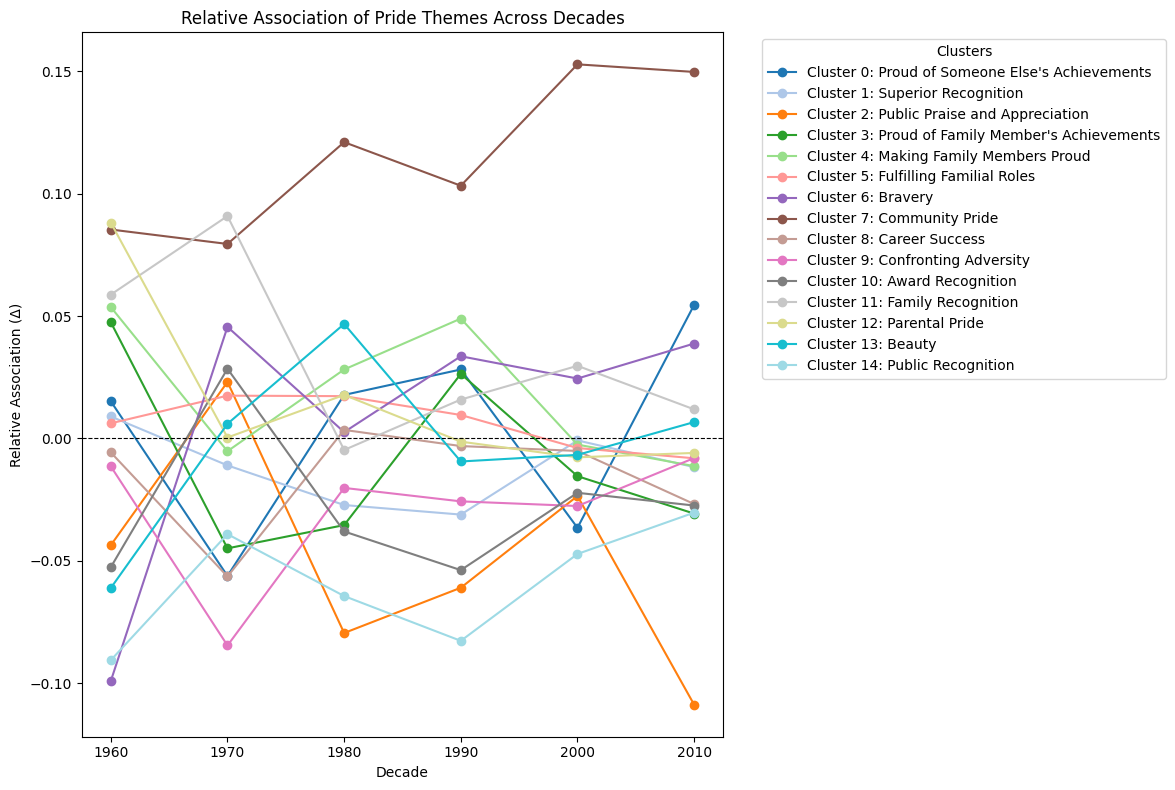

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# PRIDE: Run this code block to show ALL the PRIDE clusters

# Melt the DataFrame to a long format
df_melted = pride_cluster_df.melt(id_vars=["Cluster_ID", "c_label"], var_name="Decade", value_name="Delta")
df_melted["Decade"] = df_melted["Decade"].astype(int)  

clusters = df_melted["Cluster_ID"].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(clusters)))  
cluster_colors = dict(zip(clusters, colors))

plt.figure(figsize=(12, 8))

# Plot a line for each cluster
for cluster_id in clusters:
    subset = df_melted[df_melted["Cluster_ID"] == cluster_id]
    plt.plot(
        subset["Decade"],
        subset["Delta"],
        label=f"Cluster {cluster_id}: {subset['c_label'].iloc[0]}",
        color=cluster_colors[cluster_id],
        marker="o",
    )

plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.xticks(
    ticks=sorted(df_melted["Decade"].unique()), 
    labels=sorted(df_melted["Decade"].unique()),
)
plt.xlabel("Decade")
plt.ylabel("Relative Association (Δ)")
plt.title("Relative Association of Pride Themes Across Decades")
plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

plt.show()


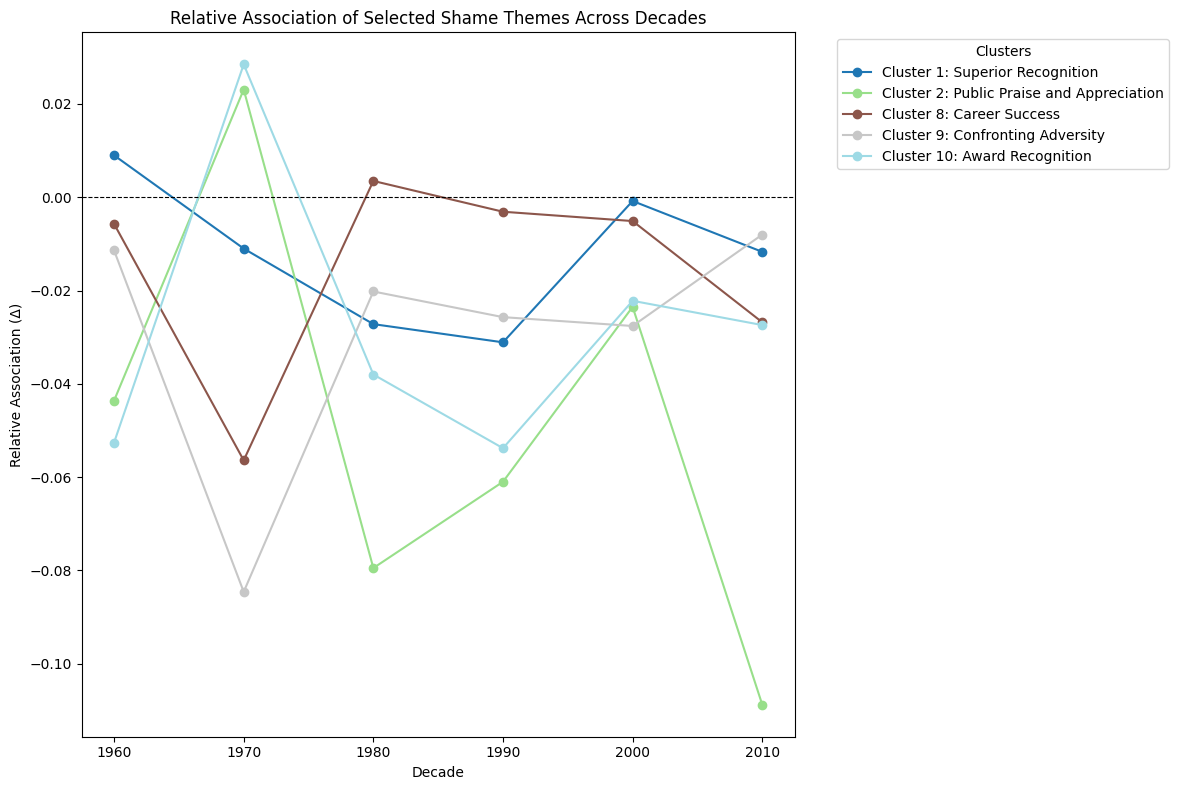

In [ ]:
# TODO: edit cluster_map to onlu include the clusters you want

cluster_map = ["Misconducts", "Family Recognition", "Community Pride"]  # Add your desired cluster labels here

# Filter the DataFrame to include only the specified clusters
df_filtered = df_melted[df_melted["c_label"].isin(pride_labels)]

# Generate unique colors for each cluster in the filtered DataFrame
clusters = df_filtered["Cluster_ID"].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(clusters)))  # Adjust colormap as needed
cluster_colors = dict(zip(clusters, colors))

plt.figure(figsize=(12, 8))

# Plot a line for each filtered cluster
for cluster_id in clusters:
    subset = df_filtered[df_filtered["Cluster_ID"] == cluster_id]
    plt.plot(
        subset["Decade"],
        subset["Delta"],
        label=f"Cluster {cluster_id}: {subset['c_label'].iloc[0]}",
        color=cluster_colors[cluster_id],
        marker="o",
    )

# Customize the plot
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.xticks(
    ticks=sorted(df_filtered["Decade"].unique()),  # Ensure all decades are shown
    labels=sorted(df_filtered["Decade"].unique()),
)
plt.xlabel("Decade")
plt.ylabel("Relative Association (Δ)")
plt.title("Relative Association of Selected Shame Themes Across Decades")
plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# Show the plot
plt.show()


### Creating the graphs: SHAME

In [20]:
shame_cluster_df = pd.read_csv(file_path+"shame_cluster_df.csv")

In [21]:
shame_cluster_df.columns = shame_cluster_df.iloc[0]
shame_cluster_df = shame_cluster_df.drop(0).reset_index(drop=True)
shame_cluster_df.head()

,Cluster_ID,1960.0,1970.0,1980.0,1990.0,2000.0,2010.0
0,0,-0.0986,0.0389,0.0517,0.0479,0.0618,0.0416
1,1,-0.1032,-0.0058,0.0100,-0.0793,-0.0873,-0.0077
2,2,-0.0795,-0.1177,-0.0958,0.0325,-0.0475,-0.0518
3,3,-0.0419,-0.0430,-0.0614,-0.0256,-0.0735,-0.0235
4,4,-0.0042,-0.0001,-0.0084,-0.0496,-0.0534,-0.0658


In [22]:
shame_cluster_df['Cluster_ID'] = shame_cluster_df.index  # Index will give you 0 to 14, so no need to manually define this.
shame_cluster_df.head()

,Cluster_ID,1960.0,1970.0,1980.0,1990.0,2000.0,2010.0
0,0,-0.0986,0.0389,0.0517,0.0479,0.0618,0.0416
1,1,-0.1032,-0.0058,0.0100,-0.0793,-0.0873,-0.0077
2,2,-0.0795,-0.1177,-0.0958,0.0325,-0.0475,-0.0518
3,3,-0.0419,-0.0430,-0.0614,-0.0256,-0.0735,-0.0235
4,4,-0.0042,-0.0001,-0.0084,-0.0496,-0.0534,-0.0658


In [28]:
shame_cluster_df['c_label'] = shame_cluster_df['Cluster_ID'].map(shame_id_to_label)

In [ ]:
# TODO: edit this to contain only the clusters you want to show
bolly_shame = [
    "Public Humiliation",
    "Public Criticism",
    "External Perception and Shame",
    "Internalized Shame"
]


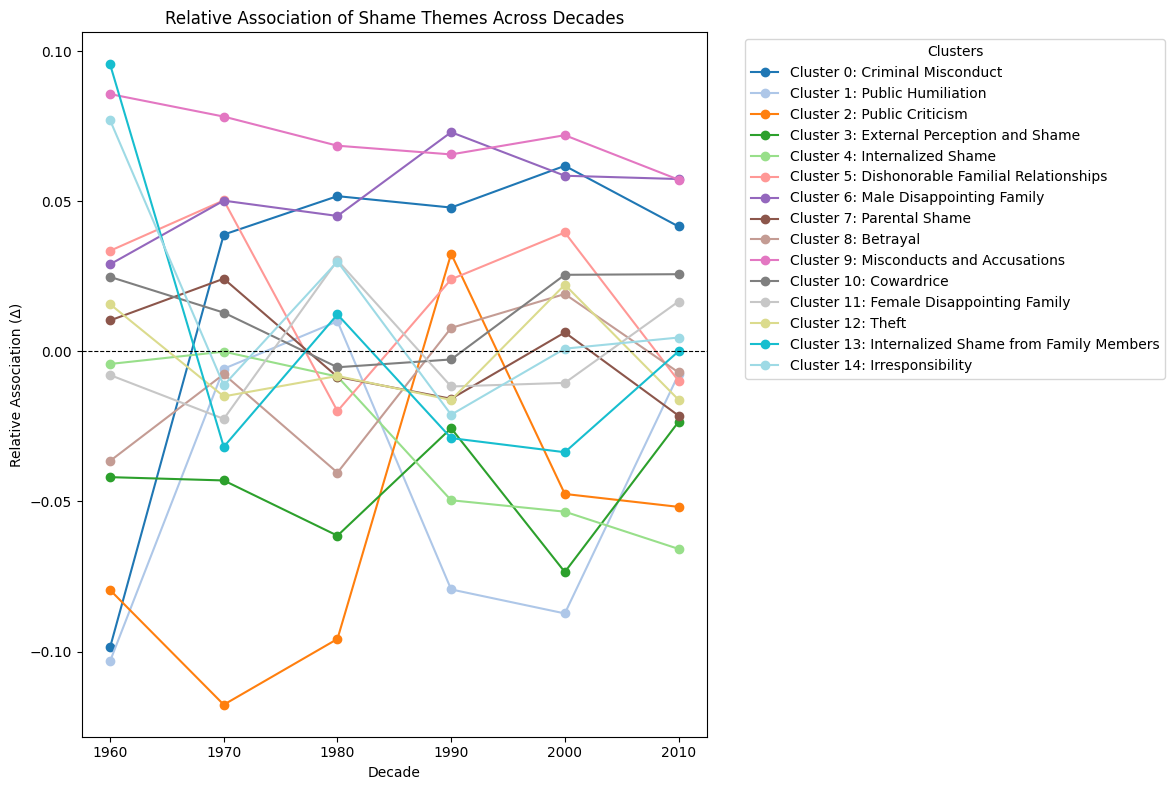

In [ ]:

df_melted = shame_cluster_df.melt(id_vars=["Cluster_ID", "c_label"], var_name="Decade", value_name="Delta")
df_melted["Decade"] = df_melted["Decade"].astype(int)  

clusters = df_melted["Cluster_ID"].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(clusters))) 
cluster_colors = dict(zip(clusters, colors))

plt.figure(figsize=(12, 8))

for cluster_id in clusters:
    subset = df_melted[df_melted["Cluster_ID"] == cluster_id]
    plt.plot(
        subset["Decade"],
        subset["Delta"],
        label=f"Cluster {cluster_id}: {subset['c_label'].iloc[0]}",
        color=cluster_colors[cluster_id],
        marker="o",
    )

plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.xticks(
    ticks=sorted(df_melted["Decade"].unique()),  
    labels=sorted(df_melted["Decade"].unique()),
)
plt.xlabel("Decade")
plt.ylabel("Relative Association (Δ)")
plt.title("Relative Association of Shame Themes Across Decades")
plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# Show the plot
plt.show()

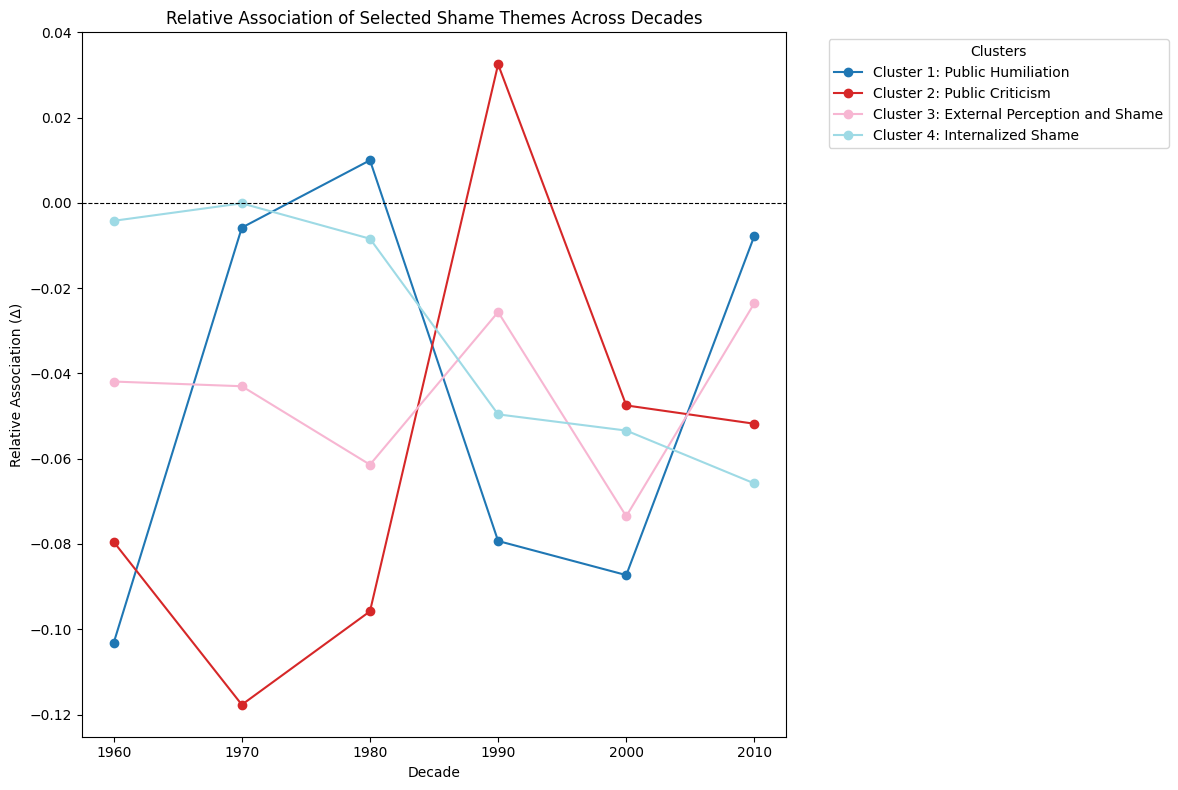

In [35]:

# Filter the DataFrame to include only the specified clusters
df_filtered = df_melted[df_melted["c_label"].isin(bolly_shame)]

# Generate unique colors for each cluster in the filtered DataFrame
clusters = df_filtered["Cluster_ID"].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(clusters)))  # Adjust colormap as needed
cluster_colors = dict(zip(clusters, colors))

plt.figure(figsize=(12, 8))

# Plot a line for each filtered cluster
for cluster_id in clusters:
    subset = df_filtered[df_filtered["Cluster_ID"] == cluster_id]
    plt.plot(
        subset["Decade"],
        subset["Delta"],
        label=f"Cluster {cluster_id}: {subset['c_label'].iloc[0]}",
        color=cluster_colors[cluster_id],
        marker="o",
    )

# Customize the plot
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.xticks(
    ticks=sorted(df_filtered["Decade"].unique()),  # Ensure all decades are shown
    labels=sorted(df_filtered["Decade"].unique()),
)
plt.xlabel("Decade")
plt.ylabel("Relative Association (Δ)")
plt.title("Relative Association of Selected Shame Themes Across Decades")
plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# Show the plot
plt.show()